In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import h5py  # compress and save features

# Loading  data

In [26]:
%%time
with h5py.File('features_train.h5', 'r') as f:
    features = np.array(f['features'])

Wall time: 5min


In [27]:
features.shape

(244768, 9736)

In [28]:
%%time
with h5py.File('features_salary.h5', 'r') as f:
    salary = np.array(f['salary'])

Wall time: 501 ms


In [29]:
salary.shape

(244768,)

In [6]:
salary_log = np.log(salary)

In [30]:
%%time
with h5py.File('features_test.h5', 'r') as f:
    feature_test = np.array(f['features_test'])

Wall time: 2min 22s


In [31]:
feature_test.shape

(122463, 9736)

In [32]:
true_salay_dataset = pd.read_csv('./dataset/random_forest_benchmark_test_rev1.csv')
true_salay = true_salay_dataset['SalaryNormalized']

# Split data

In [10]:
x_test = features[122384:244768]
x_test.shape

(122384, 9736)

In [9]:
y_test = salary[122384:244768]
y_test.shape

(122384,)

In [11]:
with h5py.File('test_data.h5', 'w') as f:
    f['salary_test'] = y_test
    f['features_test'] = x_test

In [7]:
train = features[0:122384]
train.shape

(122384, 9736)

In [8]:
salary_train = salary[0:122384]
salary_train.shape

(122384,)

In [12]:
with h5py.File('train_data.h5', 'w') as f:
    f['salary_train'] = salary_train
    f['features_train'] = train

# Loading train data

In [3]:
%%time
with h5py.File('train_data.h5', 'r') as f:
    features_train = np.array(f['features_train'])
    salary_train = np.array(f['salary_train'])

Wall time: 2min 27s


**SVM data**

In [4]:
features_svm = features_train[0:24476]
features_svm.shape

(24476, 9736)

transfrom to sparse matrix

In [5]:
from scipy import sparse

In [6]:
features_svm_scipy = sparse.csr_matrix(features_svm)

In [7]:
features_svm_scipy

<24476x9736 sparse matrix of type '<class 'numpy.float64'>'
	with 293712 stored elements in Compressed Sparse Row format>

In [8]:
salary_svm = salary_train[0:24476]
salary_svm.shape

(24476,)

**NB data**

In [19]:
features_nb = features_train[24477:48953]
features_nb.shape

(24476, 9736)

In [20]:
salary_nb = salary_train[24477:48953]
salary_nb.shape

(24476,)

**KNN data**

In [4]:
features_knn = features_train[48954:73430]
features_knn.shape

(24476, 9736)

In [5]:
from scipy import sparse
features_knn_scipy = sparse.csr_matrix(features_knn)
features_knn_scipy

<24476x9736 sparse matrix of type '<class 'numpy.float64'>'
	with 293712 stored elements in Compressed Sparse Row format>

In [6]:
salary_knn = salary_train[48954:73430]
salary_knn.shape

(24476,)

**Regression data**

In [23]:
features_re = features_train[73430:97906]
features_re.shape

(24476, 9736)

In [24]:
salary_re = salary_train[73430:97906]
salary_re.shape

(24476,)

**decision tree**

In [26]:
features_de = features_train[97906:122382]
features_de.shape

(24476, 9736)

In [27]:
salary_de = salary_train[97906:122382]
salary_de.shape

(24476,)

# SVM-R

In [10]:
from sklearn.cross_validation import train_test_split  
from sklearn.grid_search import GridSearchCV  
from sklearn.metrics import classification_report  
from sklearn.svm import SVC

In [15]:
# Split the dataset in two equal parts  
X_train, X_test, y_train, y_test = train_test_split(features_svm_scipy, salary_svm, test_size=0.5, random_state=0)  

In [17]:
# Set the parameters by cross-validation  
tuned_parameters = [{'kernel': ['linear'], 'C': [1, 10], 'max_iter':[100]}] 

In [18]:
scores = ['precision', 'recall']

In [ ]:
for score in scores:  
    print("# Tuning hyper-parameters for %s" % score)  
    print()  
  
    clf = GridSearchCV(SVC(C=1,cache_size=2048,max_iter=100), tuned_parameters, n_jobs=-1, cv=5,  
                       scoring='%s_weighted' % score)  
    clf.fit(X_train, y_train)  
  
    print("Best parameters set found on development set:")  
    print()  
    print(clf.best_params_)  
    print()  
    print("Grid scores on development set:")  
    print()  
    for params, mean_score, scores in clf.grid_scores_:  
        print("%0.3f (+/-%0.03f) for %r"  
              % (mean_score, scores.std() * 2, params))  
    print()  
  

# Tuning hyper-parameters for precision



In [ ]:
with h5py.File('model_svm.h5', 'w') as f:
    f['clf_svm'] = clf

In [ ]:
print("Detailed classification report:")  
    print()  
    print("The model is trained on the full development set.")  
    print("The scores are computed on the full evaluation set.")  
    print()  
    y_true, y_pred = y_test, clf.predict(X_test)  
    print(classification_report(y_true, y_pred))  
    print()  

clf = svm.SVC(
            C=1.0, 
            kernel='rbf', 
            #degree=3, 
            gamma='auto', 
            coef0=0.0, 
            shrinking=True, 
            probability=False, 
            tol=0.001, 
            cache_size=1024, 
            class_weight=None, 
            verbose=False, 
            max_iter=5, 
            decision_function_shape='ovr', 
            random_state=None)

# NB

# KNN

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_knn_scipy, salary_knn, test_size=0.2, random_state=50)

# Success
print("Trainning data {}, Testing data {}".format(X_train.shape[0], X_test.shape[0]))

Trainning data 19580, Testing data 4896


In [8]:
from sklearn.metrics import mean_squared_error
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    score = mean_squared_error(y_true, y_predict)
   
    return score

In [9]:
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
def fit_model_k_fold(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)
    k_fold = KFold(n_splits=10)
    
    # TODO: Create a decision tree regressor object
    regressor = KNeighborsRegressor()

    # TODO: Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'n_neighbors':range(1,10)}

    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # TODO: Create the grid search object
    grid = GridSearchCV(regressor, param_grid=params,scoring=scoring_fnc,cv=k_fold)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [10]:
# Fit the training data to the model using grid search
reg = fit_model_k_fold(X_train, y_train)

In [19]:
print ('Parameter n_neighbors is ') 
print(reg.get_params()['n_neighbors'])

Parameter n_neighbors is 
1


Train all data with n_neighbors 1

In [34]:
%%time
salary_knn = KNeighborsRegressor(n_neighbors=1).fit(features, salary).predict(feature_test)

Wall time: 1d 19h 54min 25s


In [35]:
performance_metric(true_salay,salary_knn)

251244226.48396608

In [36]:
with h5py.File('salary_knn.h5', 'w') as f:
    f['knn'] = salary_knn

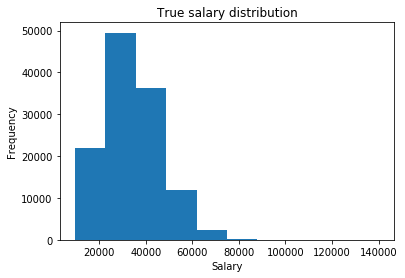

In [38]:
f1 = plt.figure(2)
plt.hist(true_salay)
plt.title('True salary distribution')  
plt.ylabel("Frequency")  
plt.xlabel("Salary")
# plt with same scale
#plt.ylim(0,0.25)
#plt.xlim(0,110000)
#plt.savefig("Orignal salary distribution.PNG", dpi = 600)
plt.show()

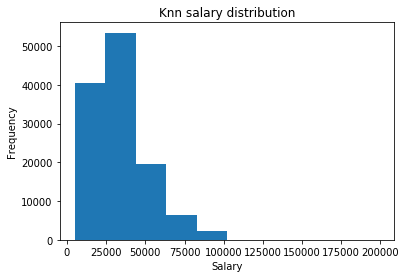

In [39]:
f1 = plt.figure(1)
plt.hist(salary_knn)
plt.title('Knn salary distribution')  
plt.ylabel("Frequency")  
plt.xlabel("Salary")
# plt with same scale
#plt.ylim(0,0.25)
#plt.xlim(0,110000)
plt.savefig("KNN salary distribution.PNG", dpi = 600)
plt.show()

# Regreesion

# decision tree  随机森然 